Reference: https://thenewstack.io/deploy-nvidia-triton-inference-server-with-minio-as-model-store/
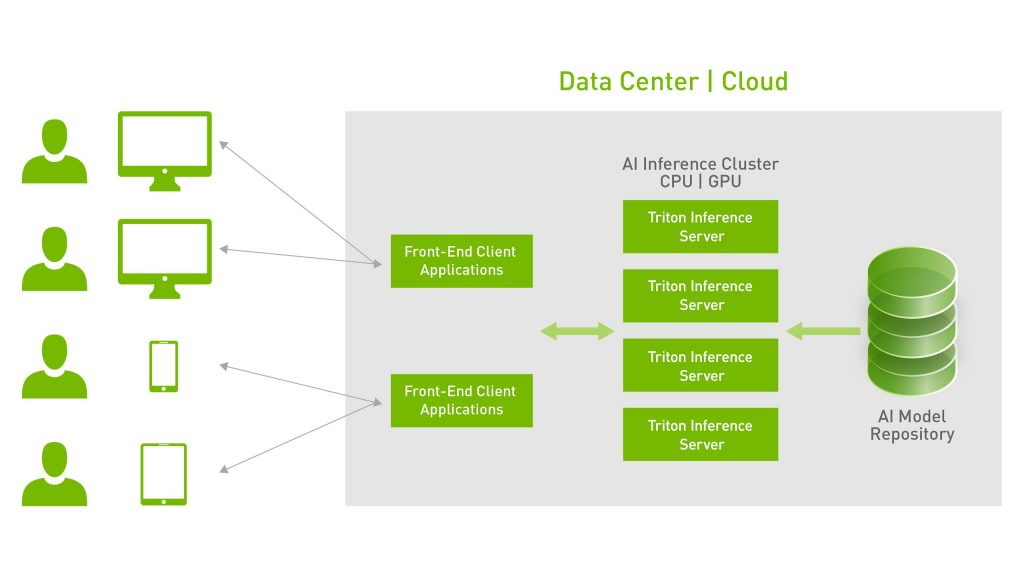

#### Make sure MINIO Setup is done

Refer [MINIO Setup](./minio_setup.ipynb)

In [1]:
import os

## Step 1 — Populate the MinIO Model Store with Sample Models

In [2]:
!git clone https://github.com/triton-inference-server/server.git

fatal: destination path 'server' already exists and is not an empty directory.


In [3]:
#### Download the sample models
!./server/docs/examples/fetch_models.sh

+ mkdir -p model_repository/inception_graphdef/1
+ wget -O /tmp/inception_v3_2016_08_28_frozen.pb.tar.gz https://storage.googleapis.com/download.tensorflow.org/models/inception_v3_2016_08_28_frozen.pb.tar.gz
--2022-12-19 12:01:10--  https://storage.googleapis.com/download.tensorflow.org/models/inception_v3_2016_08_28_frozen.pb.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.183.80, 142.250.183.208, 216.58.196.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.183.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88668554 (85M) [application/gzip]
Saving to: '/tmp/inception_v3_2016_08_28_frozen.pb.tar.gz'

/tmp/inception_v3_2 100%[===================>]  84.56M  10.0MB/s    in 9.3s    

2022-12-19 12:01:20 (9.06 MB/s) - '/tmp/inception_v3_2016_08_28_frozen.pb.tar.gz' saved [88668554/88668554]

+ cd /tmp
+ tar xzf inception_v3_2016_08_28_frozen.pb.tar.gz
+ mv /tmp/inception_v3_2016_08_28_frozen.pb model_repos

In [49]:
target_bucket = "minio-seldon/models"
modelpath = "./server/docs/examples/model_repository/*"
os.system(f"mc rb --force {target_bucket}")
os.system(f"mc mb {target_bucket}")
os.system(f"mc cp --recursive {modelpath} {target_bucket}")

Removed `minio-seldon/models` successfully.
Bucket created successfully `minio-seldon/models`.
`/Users/dileep.gadiraju/projects/AI4BHARAT/try-seldon-core/server/docs/examples/model_repository/densenet_onnx/config.pbtxt` -> `minio-seldon/models/densenet_onnx/config.pbtxt`
`/Users/dileep.gadiraju/projects/AI4BHARAT/try-seldon-core/server/docs/examples/model_repository/densenet_onnx/densenet_labels.txt` -> `minio-seldon/models/densenet_onnx/densenet_labels.txt`
`/Users/dileep.gadiraju/projects/AI4BHARAT/try-seldon-core/server/docs/examples/model_repository/inception_graphdef/config.pbtxt` -> `minio-seldon/models/inception_graphdef/config.pbtxt`
`/Users/dileep.gadiraju/projects/AI4BHARAT/try-seldon-core/server/docs/examples/model_repository/inception_graphdef/inception_labels.txt` -> `minio-seldon/models/inception_graphdef/inception_labels.txt`
`/Users/dileep.gadiraju/projects/AI4BHARAT/try-seldon-core/server/docs/examples/model_repository/simple/1/model.graphdef` -> `minio-seldon/models/s

0

In [51]:
target_bucket = "minio-seldon/models"
modelpath1 = "./model_repository/*"
# os.system(f"mc rb --force {target_bucket}")
# os.system(f"mc mb {target_bucket}")
os.system(f"mc cp --recursive {modelpath1} {target_bucket}")

`/Users/dileep.gadiraju/projects/AI4BHARAT/try-seldon-core/model_repository/densenet_onnx/1/model.onnx` -> `minio-seldon/models/densenet_onnx/1/model.onnx`
`/Users/dileep.gadiraju/projects/AI4BHARAT/try-seldon-core/model_repository/inception_graphdef/1/model.graphdef` -> `minio-seldon/models/inception_graphdef/1/model.graphdef`
Total: 0 B, Transferred: 122.51 MiB, Speed: 46.43 MiB/s


0

## Copy PyTorch cifar10 model to MINIO model-server

In [60]:
%%bash
mc config host add gcs https://storage.googleapis.com "" "" 

mc mb minio-seldon/models/cifar10 -p
mc cp gcs/seldon-models/triton/pytorch_cifar10/cifar10/ minio-seldon/models/cifar10/ --recursive

Added `gcs` successfully.
Bucket created successfully `minio-seldon/models/cifar10`.
`gcs/seldon-models/triton/pytorch_cifar10/cifar10/1/model.pt` -> `minio-seldon/models/cifar10/1/model.pt`
`gcs/seldon-models/triton/pytorch_cifar10/cifar10/config.pbtxt` -> `minio-seldon/models/cifar10/config.pbtxt`
Total: 0 B, Transferred: 255.32 KiB, Speed: 349.41 KiB/s


## Step 2 — Deploy Triton Inference Server

In [95]:
#### Create Seldon ns and set as current context
!kubectl create namespace seldon
!kubectl config set-context $(kubectl config current-context) --namespace=seldon
!kubectl config view | grep namespace

Error from server (AlreadyExists): namespaces "seldon" already exists
Context "kind-seldon" modified.
    namespace: seldon


In [96]:
%%writefile model-server-secret.yaml

apiVersion: v1
kind: Secret
metadata:
  name: model-server-secret
  namespace: seldon
type: Opaque
stringData:
  RCLONE_CONFIG_S3_TYPE: s3
  RCLONE_CONFIG_S3_PROVIDER: minio
  RCLONE_CONFIG_S3_ACCESS_KEY_ID: minioadmin
  RCLONE_CONFIG_S3_SECRET_ACCESS_KEY: minioadmin
  RCLONE_CONFIG_S3_ENDPOINT: http://minio.minio-system.svc.cluster.local:9000
  RCLONE_CONFIG_S3_ENV_AUTH: "false"

Overwriting model-server-secret.yaml


In [97]:
!kubectl delete -f model-server-secret.yaml
!kubectl create -f model-server-secret.yaml

secret "model-server-secret" deleted
secret/model-server-secret created


In [98]:
%%writefile model-server-triton-deploy.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: model-server-triton
  namespace: seldon
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: "true"
  name: model-server-triton
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: s3://models
      envSecretRefName: model-server-secret      
      name: model-server-triton
      type: MODEL
    name: default
    replicas: 1
  protocol: v2

Overwriting model-server-triton-deploy.yaml


In [99]:
!kubectl delete -f model-server-triton-deploy.yaml
!kubectl create -f model-server-triton-deploy.yaml

seldondeployment.machinelearning.seldon.io "model-server-triton" deleted
seldondeployment.machinelearning.seldon.io/model-server-triton created


In [100]:
### logs from model-server-triton pod
# !kubectl describe seldondeployments model-server-triton
!kubectl get pods -l seldon-deployment-id=model-server-triton  -o custom-columns=:metadata.name


model-server-triton-default-0-model-server-triton-b4b55fd7dgx74
model-server-triton-default-0-model-server-triton-b4b55fd7fpk8w


#### Test TorchScript CIFAR10 Model on Triton Model Server

In [101]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf

train, test = tf.keras.datasets.cifar10.load_data()
X_test, y_test = test
X_test = X_test.astype("float32") / 255
print(X_test.shape, y_test.shape)
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

(10000, 32, 32, 3) (10000, 1)


In [102]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=10, shuffle=False, num_workers=2
)
for data in testloader:
    images, labels = data
    break

Files already downloaded and verified


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63672  100   309  100 63363   6716  1345k --:--:-- --:--:-- --:--:-- 1381k


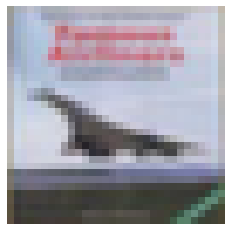

class: airplane
prediction: airplane


In [107]:
import json
from subprocess import PIPE, Popen, run

import numpy as np

idx = 3
test_example = images[idx : idx + 1]
test_example = test_example.tolist()
payload = (
    '{"inputs":[{"name":"input__0","datatype":"FP32","shape":[1, 3, 32, 32],"data":'
    + f"{test_example}"
    + "}]}"
)
cmd = f"""curl -d '{payload}' \
   http://localhost:8004/seldon/seldon/model-server-triton/v2/models/cifar10/infer \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True, stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res = json.loads(raw)
arr = np.array(res["outputs"][0]["data"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis("off")
plt.show()

print("class:", class_names[labels[idx]])
print("prediction:", class_names[arr.argmax()])